In [145]:
import pandas as pd
from sklearn.utils import shuffle
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
import ast
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, PrecisionRecallDisplay, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from zoobot.tensorflow.data_utils import image_datasets
from zoobot.tensorflow.estimators import define_model, preprocess
from zoobot.tensorflow.predictions import predict_on_dataset

In [17]:
df = shuffle(pd.read_csv('C:/Users/oryan/Documents/esac-project/cutouts/hubble-training-100-valid/hubble-valid-manifest-checked.csv',index_col = 0).reset_index())

In [18]:
len(df)

394

In [19]:
df

,index,thumbnail_path,RA,DEC,interacting
115,AHZ2001jou,/mmfs1/scratch/hpc/60/oryan/fromMAST/thumbnail...,149.681054,2.695037,0
236,AHZ20007kr,/mmfs1/scratch/hpc/60/oryan/fromMAST/thumbnail...,149.633946,1.625473,0
331,AHZ2001pvo,/mmfs1/scratch/hpc/60/oryan/fromMAST/thumbnail...,150.346317,2.003955,1
348,AHZ2001r16,/mmfs1/scratch/hpc/60/oryan/fromMAST/thumbnail...,150.273939,2.456319,1
143,AHZ2000ha4,/mmfs1/scratch/hpc/60/oryan/fromMAST/thumbnail...,150.557320,1.984174,0
...,...,...,...,...,...
156,AHZ40000mn,/mmfs1/scratch/hpc/60/oryan/fromMAST/thumbnail...,53.282673,-28.057021,0
18,AHZ2000e7l,/mmfs1/scratch/hpc/60/oryan/fromMAST/thumbnail...,149.614079,1.916379,0
78,AHZ200135i,/mmfs1/scratch/hpc/60/oryan/fromMAST/thumbnail...,149.598577,2.310079,0
353,AHZ2001rap,/mmfs1/scratch/hpc/60/oryan/fromMAST/thumbnail...,149.881551,2.340114,1


In [25]:
df_local = (
    df.assign(file_loc = df.thumbnail_path.apply(lambda x: 'C:/Users/oryan/Documents/esac-project/cutouts/hubble-training-100-valid/' + os.path.basename(x)))
)

### Making Predictions

#### Loading the Model

In [27]:
model_loc = 'C:/Users/oryan/Documents/zoobot_new/pretrained-models/replicated_train_only_greyscale_tf/replicated_train_only_greyscale_tf/checkpoint'
finetune_loc = 'C:/Users/oryan/Documents/zoobot_new/model-logs/2022-05-05-HEC-all-unfrozen-0.89/finetuned/checkpoint'

In [29]:
input_size = 300
crop_size = int(0.75 * input_size)
resize_size = 224

In [30]:
base_model = define_model.load_model(
    checkpoint_loc = model_loc,
    include_top = False,
    input_size = input_size,
    crop_size = crop_size,
    resize_size = resize_size,
    expect_partial = True
)

In [33]:
para_relu = layers.PReLU()

In [34]:
new_head = tf.keras.Sequential([
        layers.InputLayer(input_shape=(7,7,1280)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64,activation=para_relu),
        #layers.Dropout(0.75),
        layers.Dense(64,activation='elu'),
        layers.Dropout(0.25),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64,activation = para_relu),
        layers.Dropout(0.25),
        layers.Dense(1,activation='sigmoid',name='sigmoid_output')
    ])

In [36]:
model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_size, input_size,1)),
        base_model,
        new_head
    ])

In [37]:
model.load_weights(finetune_loc).expect_partial()

#### Process Data

In [40]:
image_paths = list(df_local.file_loc)

In [41]:
file_format = 'png'
batch_size = 64

In [42]:
raw_image_ds = image_datasets.get_image_dataset([str(x) for x in image_paths], file_format, input_size, batch_size)

In [43]:
preprocessing_config = preprocess.PreprocessingConfig(
    label_cols = [],
    input_size = input_size,
    make_greyscale = True,
    normalise_from_uint8 = True
)

In [45]:
image_ds = preprocess.preprocess_dataset(raw_image_ds, preprocessing_config)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [48]:
save_loc = f'C:/Users/oryan/Documents/esac-project/predictions/predictions-{len(image_paths)}.csv'

In [49]:
save_loc

'C:/Users/oryan/Documents/esac-project/predictions/predictions-394.csv'

In [51]:
n_samples = 1
label_cols = ['interacting']

In [52]:
predict_on_dataset.predict(image_ds, model, n_samples, label_cols, save_loc)

### Conducting Diagnostics

#### Prepping Data

In [55]:
predictions = pd.read_csv(save_loc,index_col = 0).reset_index()

In [60]:
predictions_df = (
    predictions.assign(index = predictions.id_str.apply(lambda x: os.path.basename(x).replace('_300_300_3.png','')))
)

In [70]:
merged_pred = (
    predictions_df.merge(df, on='index',how='left')
    .drop(columns = ['id_str', 'thumbnail_path','RA','DEC'])
    .rename(columns={'interacting_pred':'prediction_list', 'interacting':'label'})
)

In [75]:
readable_pred = merged_pred.assign(prediction = merged_pred.prediction_list.apply(lambda x: ast.literal_eval(x)[0])).drop(columns='prediction_list')

In [76]:
readable_pred

,index,label,prediction
0,AHZ2001jou,0,0.057006
1,AHZ20007kr,0,0.010994
2,AHZ2001pvo,1,0.997417
3,AHZ2001r16,1,0.999265
4,AHZ2000ha4,0,0.115063
...,...,...,...
389,AHZ40000mn,0,0.812657
390,AHZ2000e7l,0,0.165567
391,AHZ200135i,0,0.023116
392,AHZ2001rap,1,0.973997


In [77]:
cutoff = 0.5

In [80]:
binary_pred = (
    readable_pred.assign(binary_prediction = readable_pred.prediction.apply(lambda x: 1 if x >= cutoff else 0))
)

In [86]:
binary_pred.label.value_counts()

0    289
1    105
Name: label, dtype: int64

In [81]:
binary_pred

,index,label,prediction,binary_prediction
0,AHZ2001jou,0,0.057006,0
1,AHZ20007kr,0,0.010994,0
2,AHZ2001pvo,1,0.997417,1
3,AHZ2001r16,1,0.999265,1
4,AHZ2000ha4,0,0.115063,0
...,...,...,...,...
389,AHZ40000mn,0,0.812657,1
390,AHZ2000e7l,0,0.165567,0
391,AHZ200135i,0,0.023116,0
392,AHZ2001rap,1,0.973997,1


#### Making Confusion Matrices

In [85]:
cf_matrix = confusion_matrix(binary_pred.label, binary_pred.binary_prediction)
print(cf_matrix)

[[266  23]
 [ 19  86]]


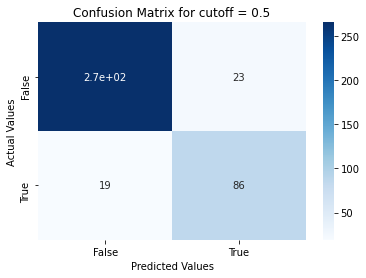

In [95]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title(f'Confusion Matrix for cutoff = 0.5')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

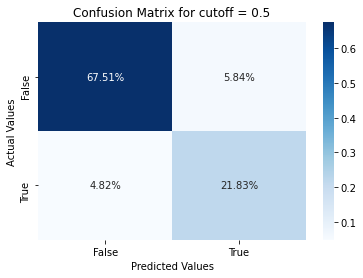

In [97]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues')

ax.set_title(f'Confusion Matrix for cutoff = 0.5')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

#### Accuracy Graphs

In [107]:
def get_accuracy(df, cut):
    df_pred = df.assign(binary_prediction = df.prediction.apply(lambda x: 0 if x <= cut else 1))
    right_df = df_pred.query('binary_prediction == label')
    accuracy = len(right_df)/len(df_pred)
    return accuracy

In [108]:
cutoffs = np.linspace(0.01,0.99, 1000)

In [109]:
accuracy_fine = {}
for i in range(len(cutoffs)):
    accuracy_fine[cutoffs[i]] = [get_accuracy(readable_pred, cutoffs[i])]
    
accuracy_fine_df = (
    pd.DataFrame(accuracy_fine)
    .T
    .reset_index()
    .rename(columns={'index':'binary_cut',0:'Accuracy'})
)

In [151]:
accuracy_fine_df.query('Accuracy == Accuracy.max()')

,binary_cut,Accuracy
785,0.780070,0.916244
786,0.781051,0.916244
787,0.782032,0.916244
788,0.783013,0.916244
789,0.783994,0.916244
790,0.784975,0.916244
791,0.785956,0.916244
792,0.786937,0.916244
793,0.787918,0.916244
799,0.793804,0.916244


<AxesSubplot:title={'center':'Accuracy vs Cut in SDSS Example'}, xlabel='Prediction Cutoff', ylabel='Accuracy'>

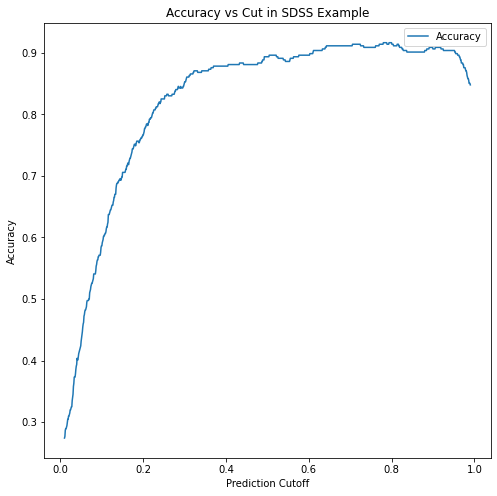

In [110]:
accuracy_fine_df.plot(
    x='binary_cut',
    y='Accuracy',
    figsize=(8,8),
    xlabel='Prediction Cutoff',
    ylabel='Accuracy',
    title='Accuracy vs Cut in SDSS Example'
)

#### ROC Curves

In [117]:
fpr, tpr, thresholds_roc = roc_curve(list(readable_pred.label),list(readable_pred.prediction))

In [114]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

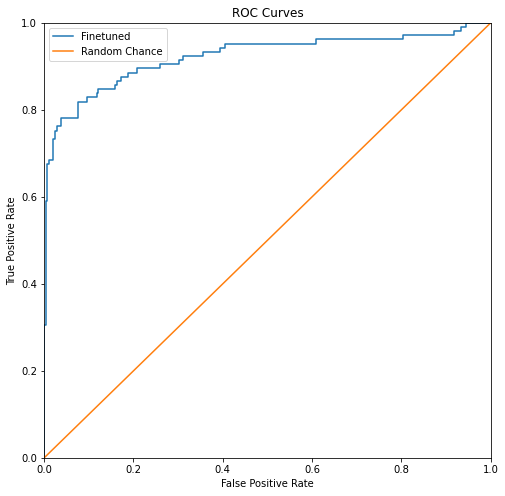

In [115]:
plt.figure(figsize=(8,8))
plt.plot(fpr,tpr)
plt.plot(x,y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('ROC Curves')
plt.legend(['Finetuned','Random Chance'])
plt.show()

#### Precision Recall

In [119]:
precision, recall, thresholds_pr = precision_recall_curve(readable_pred.label, readable_pred.prediction)

In [140]:
x = np.linspace(1, 0, 100)
y = np.linspace(0, 1, 100)

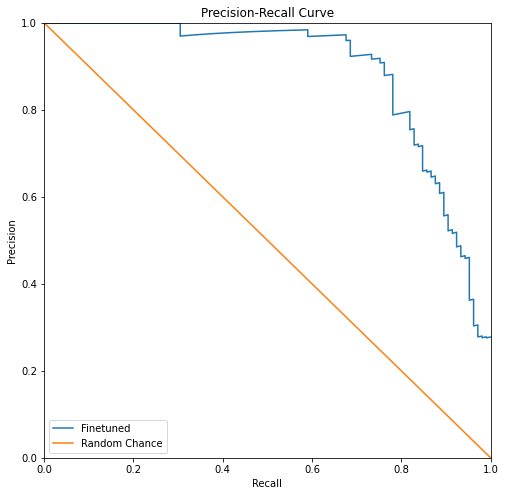

In [144]:
plt.figure(figsize=(8,8))
plt.plot(recall,precision)
plt.plot(x,y)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Precision-Recall Curve')
plt.legend(['Finetuned','Random Chance'])
plt.show()

For a cutoff of 0.5, we have a precision value of:

In [147]:
precision = precision_score(binary_pred.label, binary_pred.binary_prediction)
precision

0.7889908256880734

#### Where Accuracy is Max:

In [157]:
cutoff_m = accuracy_fine_df.query('Accuracy == Accuracy.max()').iloc[int(len(accuracy_fine_df.query('Accuracy == Accuracy.max()'))/2)].binary_cut

In [159]:
binary_pred_max = (
    readable_pred
    .assign(binary_prediction = readable_pred.prediction.apply(lambda x: 1 if x >= cutoff_m else 0 ))
)

In [160]:
precision = precision_score(binary_pred_max.label, binary_pred_max.binary_prediction)
precision

0.9090909090909091

In [ ]:
gz-